## Reminder of purpose

With the advance of machine learning technology and the utilization of generative models, machines can now automatically generate posts or even news that can hardly be discerned from the real authentic ones that are written by a human being. While such technologies can save news editors much trouble in writing a news report, it can also result in problems such as distorting facts and misleading public opinions. Thus, being able to assess the veracity of a news is very important. However, considering the high level of technology that is used in generating those fake news, distinguishing them from real ones can also be a complex and cumbersome task. Therefore, we want to build a model that can detect fake news versus real ones to help preserve the original objective of news reports: to spread objective, updated, and true information and to promote positive engagement in social development.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing Packages

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import nltk
from nltk import *
from nltk import word_tokenize
from tensorflow.keras.preprocessing.text import Tokenizer
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Input, LSTM, SimpleRNN, Conv1D, MaxPool1D, Bidirectional,\
Dropout, MaxPooling1D, Activation
from tensorflow.keras.models import Model
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


True

### Data Pre Processing and Loading

In [ ]:
train_df = pd.read_csv('/content/fnn_train.csv',index_col = 0)
val_df = pd.read_csv('/content/fnn_dev.csv', index_col = 0)
test_df = pd.read_csv('/content/fnn_test.csv',index_col = 0)

# print the size of each dataset
print("train:", len(train_df))
print("validation:", len(val_df))
print("test:", len(test_df))


# reset index
train_df.reset_index(drop = True, inplace = True)
val_df.reset_index(drop=True, inplace = True)
test_df.reset_index(drop = True, inplace = True)

# concatenate three dataframes for preprocessing
df = pd.concat([train_df,val_df,test_df], ignore_index=True)
df.drop('date',axis=1,inplace = True)
df = df.rename(columns= {'paragraph_based_content':'paragraph','fullText_based_content':'text'})

train: 15212
validation: 1058
test: 1054


In [ ]:
# Get dummies targets
dummy = pd.get_dummies(df['label_fnn'])

df = df.join(dummy, how = 'inner')
df = df.drop(columns = ['fake','label_fnn'])
df.head(2)


,speaker,statement,sources,paragraph,text,real
0,Joe Wilkinson,A national organization says Georgia has one o...,['http://www.ajc.com/news/georgia-politics-ele...,['A coalition of government watchdog groups la...,A coalition of government watchdog groups last...,0
1,Rick Scott,"Says Barack Obama's health care law ""will be t...",['http://www.youtube.com/watch?v=TaC0mKApf9Q&f...,['As Supreme Court justices embarked on three ...,As Supreme Court justices embarked on three da...,0


In [ ]:
#Function to tokenize and remove stop words
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')
import regex as re
import nltk
nltk.download("stopwords")
nltk.download('punkt')


stop_words =set(stopwords.words("english"))
wnl = nltk.stem.WordNetLemmatizer()
tokenizer = RegexpTokenizer(r'\w+')
    
def preprocess(row):

    row = re.sub('[%\n]', ' ', row)
    row = re.sub('[%’""-+\,.:<>-]', '', row)
    row = row.lstrip('[').rstrip(']')
    row = re.sub('[^A-Za-z0-9 ]+','',row)

    #lower case and remove white spaces
    row = row.lower()
    row = row.strip()

    #tokenize and remove stopwords
    tokens = tokenizer.tokenize(row)
    tokens = [w for w in tokens if w not in stop_words]
    lemma = [wnl.lemmatize(w) for w in tokens]
    return lemma

def rejoin_words(row):
    joined_words = ( " ".join(row))
    return joined_words


df['words_s'] = df['statement'].apply(preprocess)
df['processed_s'] = df['words_s'].apply(rejoin_words)

df['words_p'] = df['paragraph'].apply(preprocess)
df['processed_p'] = df['words_p'].apply(rejoin_words)

df.head(2)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


,speaker,statement,sources,paragraph,text,real,words_s,processed_s,words_p,processed_p
0,Joe Wilkinson,A national organization says Georgia has one o...,['http://www.ajc.com/news/georgia-politics-ele...,['A coalition of government watchdog groups la...,A coalition of government watchdog groups last...,0,"[national, organization, say, georgia, one, am...",national organization say georgia one america ...,"[coalition, government, watchdog, group, last,...",coalition government watchdog group last week ...
1,Rick Scott,"Says Barack Obama's health care law ""will be t...",['http://www.youtube.com/watch?v=TaC0mKApf9Q&f...,['As Supreme Court justices embarked on three ...,As Supreme Court justices embarked on three da...,0,"[say, barack, obamas, health, care, law, bigge...",say barack obamas health care law biggest jobk...,"[supreme, court, justice, embarked, three, day...",supreme court justice embarked three day oral ...


In [ ]:
#split into train, validation, test set
from sklearn.model_selection import train_test_split
'''
train_df = df.iloc[:15212]
val_df = df.iloc[15212:16270]
test_df = df.iloc[16270:]
'''
y = df['real'].values
X = df.drop(['real'],axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=23)


14420

### Analyze Patterns

<Figure size 720x720 with 0 Axes>

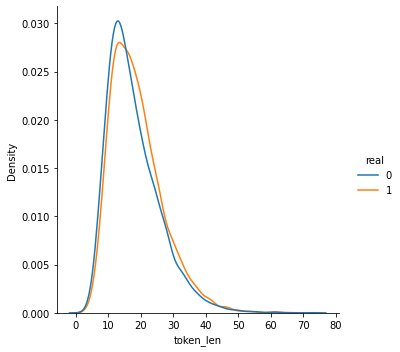

In [ ]:
import seaborn as sns
plt.figure(figsize = (10,10))
df['token_len'] = df['statement'].map(lambda x: len(x.split()))
sns.displot(df,x = "token_len",hue = 'real',kind = 'kde')

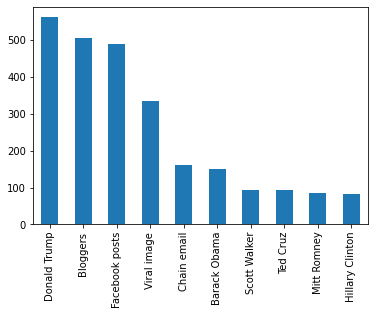

In [ ]:
speaker_fake = df[df['real']==0]['speaker']
fake_speaker_10 = speaker_fake.value_counts().iloc[:10].plot(kind = 'bar')

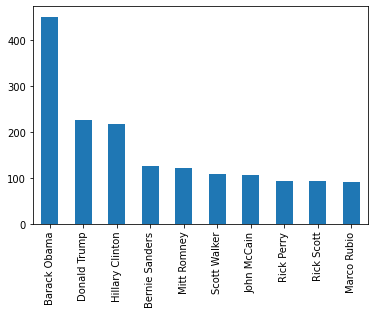

In [ ]:
speaker_real = df[df['real']==1]['speaker']
real_speaker_10 = speaker_real.value_counts().iloc[:10].plot(kind = 'bar')

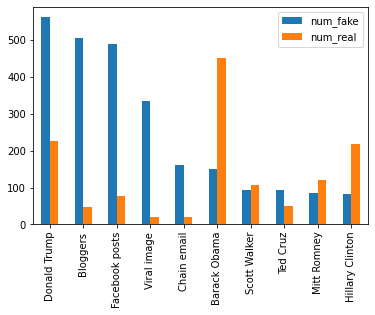

In [ ]:
fake_speaker = pd.DataFrame(speaker_fake.value_counts())
real_speaker = pd.DataFrame(speaker_real.value_counts())
all_speaker = fake_speaker.join(real_speaker, lsuffix = "_fake", rsuffix = "_real")
all_speaker.rename(columns = {"speaker_fake":'num_fake', "speaker_real": "num_real"}, inplace = True)
all_speaker.sort_values(by = "num_fake", ascending = False).iloc[:10].plot(kind = "bar")

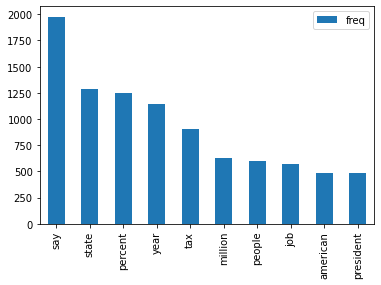

In [ ]:
# fake vs. real: word frequencies
real_df = df[df['real'] == 1]
real_tokens = [item for items in real_df['words_s'] for item in items]
fdist_real = FreqDist(real_tokens)
wordFreqTable_real = pd.DataFrame.from_dict(fdist_real, orient='index',columns=['freq']).sort_values(by='freq', ascending=False)
wordFreqTable_real.iloc[:10].plot(kind='bar')

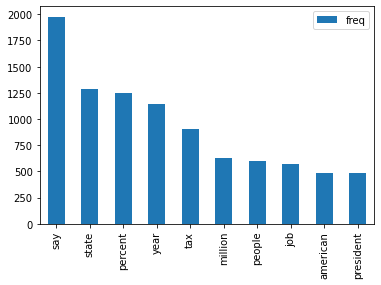

In [ ]:
fake_df = df[df['real'] == 0]
fake_tokens = [item for items in real_df['words_s'] for item in items]
fdist_fake = FreqDist(fake_tokens)
wordFreqTable_fake = pd.DataFrame.from_dict(fdist_fake, orient='index',columns=['freq']).sort_values(by='freq', ascending=False)
wordFreqTable_fake.iloc[:10].plot(kind='bar')

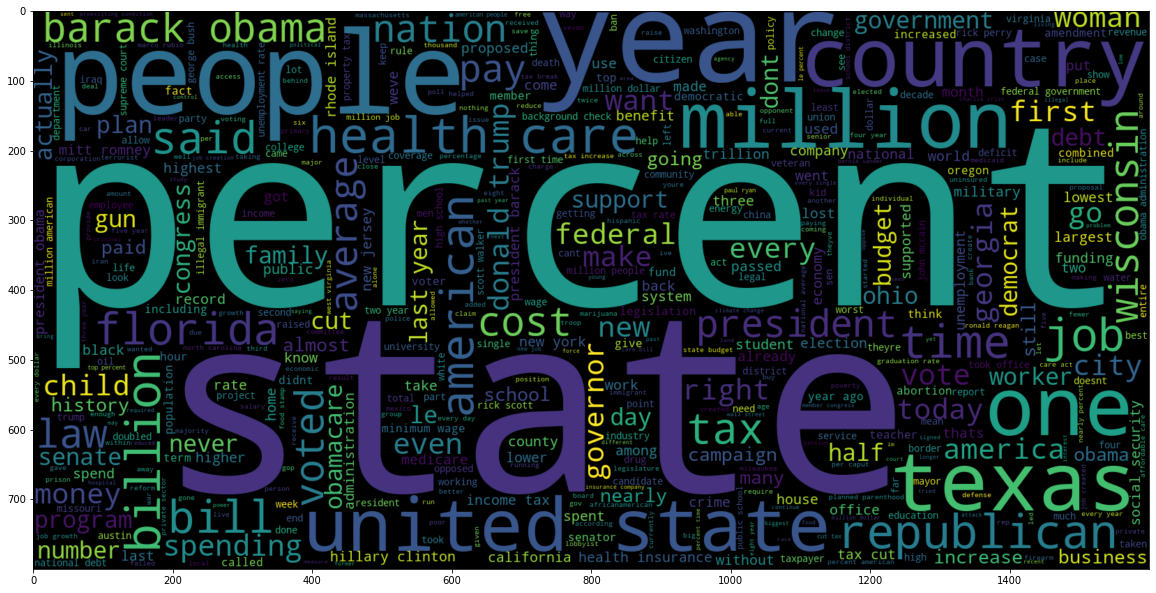

In [ ]:
from wordcloud import WordCloud,STOPWORDS
plt.figure(figsize = (20,20)) 
real_tokens = [token for token in real_tokens if token != 'says' and token != 'say']
wc = WordCloud(max_words = 500 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(real_tokens))
plt.imshow(wc , interpolation = 'bilinear')

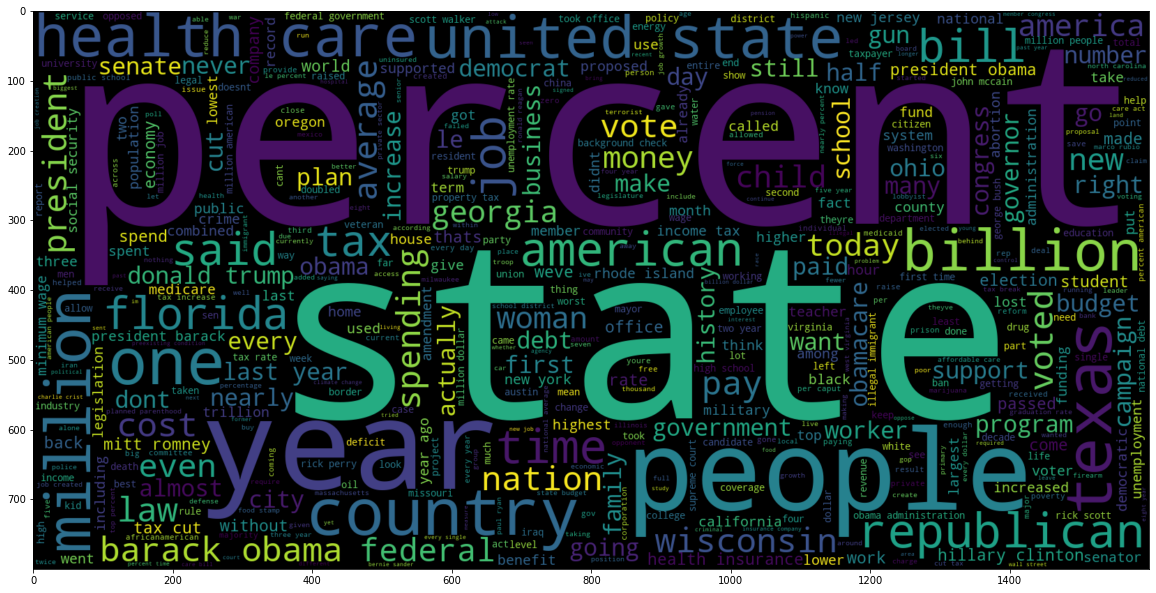

In [ ]:
plt.figure(figsize = (20,20)) 
fake_tokens = [token for token in fake_tokens if token != 'says' and token != 'say']
wc = WordCloud(max_words = 500 , width = 1600 , height = 800 , stopwords = STOPWORDS).generate(" ".join(fake_tokens))
plt.imshow(wc , interpolation = 'bilinear')

### Bag of Words

TFIDF Bag of Words

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

# train tf-idf
train_statement = X_train["processed_s"].values.tolist()
test_statement = X_test["processed_s"].values.tolist()
tfidf_vectorizer = TfidfVectorizer().fit(train_statement)
train_matrix = tfidf_vectorizer.transform(train_statement)
test_matrix = tfidf_vectorizer.transform(test_statement)

words  = tfidf_vectorizer.get_feature_names()
train_tfidf = pd.DataFrame(train_matrix.todense(), columns = words)
test_tfidf = pd.DataFrame(test_matrix.todense(), columns = words)

Bag of Words

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

def cv(data):
    countv = CountVectorizer()
    emb = countv.fit_transform(data)
    return emb, countv

train_statement = X_train['processed_s'].tolist()

train_counts, count_vectorizer = cv(train_statement)
test_counts = count_vectorizer.transform(X_test['processed_s'].tolist())

### Word Embeddings

word2vec

In [ ]:
import gensim

word2vec_path = "GoogleNews-vectors-negative300.bin.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [ ]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, statements, generate_missing=False):
    embeddings = statements['words_s'].apply(lambda x: get_average_word2vec(x, vectors,generate_missing=generate_missing))
    return list(embeddings)

In [ ]:
train_w2v = get_word2vec_embeddings(word2vec, X_train[['words_s']])
test_w2v = get_word2vec_embeddings(word2vec,X_test[['words_s']])

glove

In [ ]:
#Use glove word embeddings (twitter)
embedding_file = 'glove.twitter.27B.100d.txt'

In [ ]:
#Updated glove embeddings this one works better.
embeddings_index = {};
with open(embedding_file, encoding="utf8") as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((len(word_index)+1, 100));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

In [ ]:
print(embedding_matrix.shape)
plt.plot(embedding_matrix[16])
plt.plot(embedding_matrix[37])
plt.plot(embedding_matrix[18])
plt.title('example vectors')

Visualize the embeddings

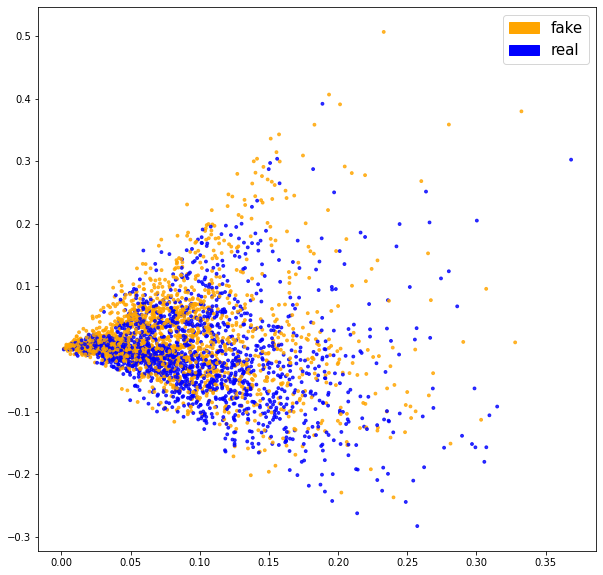

In [ ]:
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import matplotlib.patches as mpatches


def plot_LSA(test_data, test_labels, savepath="PCA.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            orange_patch = mpatches.Patch(color='orange', label='fake')
            blue_patch = mpatches.Patch(color='blue', label='real')
            plt.legend(handles=[orange_patch, blue_patch], prop={'size': 15})

fig = plt.figure(figsize=(10,10))          
plot_LSA(test_tfidf, y_test) #change the input here to generate visualizations for different embeddings
plt.show()

## Traditional Models

Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_auc_score

import warnings
warnings.filterwarnings('ignore')

#find the optimal regularization parameter using GridSearchCV
params = {"C":[0.01,0.1,1,10]}
lg = LogisticRegression()

grid = GridSearchCV(lg, params)
grid.fit(train_tfidf, y_train)

print(grid.best_params_)
print(grid.best_score_)

In [42]:
# use the best parameters from gridserachCV
lg_grid = LogisticRegression(penalty='l2',C=0.1)
lg_grid.fit(train_tfidf,y_train)
lr_pred_tr = lg_grid.predict(train_tfidf)
lr_pred_te = lg_grid.predict(test_tfidf)
print("The roc_auc_score is:", roc_auc_score(y_test,lg_grid.predict_proba(test_tfidf)[:,1]))
print("The training accuracy is:",metrics.accuracy_score(y_train, lr_pred_tr))
print("The test accuracy is :", metrics.accuracy_score(y_test, lr_pred_te))

The roc_auc_score is: 0.6766741717679812
The training accuracy is: 0.6973807634028429
The test accuracy is : 0.6320346320346321


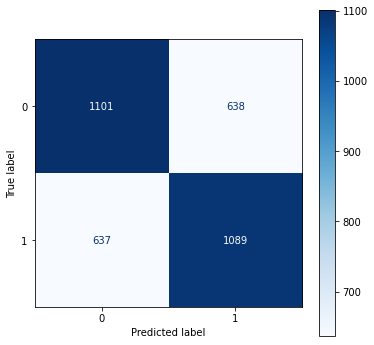

In [43]:
#confusion matrix
from sklearn.metrics import plot_confusion_matrix

fig, ax = plt.subplots(figsize=(6, 6))
plot_confusion_matrix(lg_grid,test_tfidf,y_test,cmap=plt.cm.Blues,ax = ax,values_format = '')

Random Forest

In [ ]:
#Gridsearch bag of words
params = {'n_estimators':[300,250,200,350],'max_depth':[none]}

rf_optimal_params = GridSearchCV(RandomForestClassifier(random_state=10), params)
rf_optimal_params.fit(train_counts, y_train)
rf_optimal_params.best_params_

In [ ]:
#Gridsearch example tf-idf
params = {'n_estimators':[300,250,200,350],'max_depth':[none]}

rf_optimal_params = GridSearchCV(RandomForestClassifier(random_state=10), params)
rf_optimal_params.fit(train_tfidf, y_train)
rf_optimal_params.best_params_

In [ ]:
#Input: Bag of Words
random_forest = RandomForestClassifier(n_estimators = 350, oob_score = True)
random_forest.fit(train_counts,y_train)

rf_pred_tr = random_forest.predict(train_counts)
print("Training accuracy for random forest: ", metrics.accuracy_score(y_train, rf_pred_tr))
rf_pred_te = random_forest.predict(train_counts)
print("Testing accuracy for random forest", metrics.accuracy_score(y_test, rf_pred_te))

print("The oob_score is:",random_forest.oob_score_)
print("The roc_auc_score is:", roc_auc_score(y_test,random_forest.predict_proba(test_counts)[:,1]))

In [ ]:
#confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))
plt.rcParams.update({'font.size': 20})
plot_confusion_matrix(random_forest,test_counts,y_test,cmap=plt.cm.Blues,ax = ax,values_format = '')

In [ ]:
#get feature importances
def get_most_important_features(vectorizer, model, n=5):
    index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}
    word_importance = [(fi,index_to_word[i]) for i,fi in enumerate(model.feature_importances_)]
    sorted_tops = sorted(word_importance, key = lambda x: x[0],reverse = True)[:n]
    return sorted_tops
    
importance = get_most_important_features(count_vectorizer, random_forest, 10)
importance

In [ ]:
#Random Forest TF-IDF version. For LIME.
random_forest2 = RandomForestClassifier(random_state = 10, 
                                       max_depth = None,
                                       n_estimators = 350)
random_forest2.fit(train_tfidf,y_train)
random_forest2_tepred = random_forest2.predict(test_tfidf)
print("Testing accuracy for random forest", metrics.accuracy_score(y_test,random_forest2_tepred))
print("The roc_auc_score is:", roc_auc_score(y_test,random_forest2.predict_proba(test_tfidf)[:,1]))
print(classification_report(y_test, random_forest2_tepred))

Naive Bayes

In [ ]:
from sklearn.naive_bayes import MultinomialNB
clf = MultinomialNB()
clf.fit(train_tfidf, y_train)

nb_pred_train = clf.predict(train_tfidf)
nb_pred_test = clf.predict(test_tfidf)

print("train accuracy: ", clf.score(train_tfidf, y_train))
print("test accuracy: ", clf.score(test_tfidf, y_test))
print("The roc_auc_score is:", roc_auc_score(y_test,clf.predict_proba(test_tfidf)[:,1]))

train accuracy:  0.786781153041345
test accuracy:  0.6242424242424243
The roc_auc_score is: 0.6805768688735085


In [ ]:
from sklearn.metrics import classification_report
prediction = clf.predict(test_counts)
print(classification_report(prediction,y_test))
#precision: True positives/(True positives + False positives)
#recall: True positives/(True positives + False Negatives)

              precision    recall  f1-score   support

           0       0.56      0.64      0.60      1527
           1       0.68      0.61      0.64      1938

    accuracy                           0.62      3465
   macro avg       0.62      0.63      0.62      3465
weighted avg       0.63      0.62      0.62      3465



## Neural Networks

In [ ]:
# tokenize to sequence, padding
# get list of all words
total_word = []
max_len = 0
for i in X_train["words_s"].tolist():
    max_len = max(max_len, len(i))
    for j in i:
        total_word.append(j)
total_word = list(set(total_word))

# tokenize to sequences
tokenizer = Tokenizer(num_words = len(total_word))
tokenizer.fit_on_texts(X_train["processed_s"])
train_sequences = tokenizer.texts_to_sequences(X_train["processed_s"])
test_sequences = tokenizer.texts_to_sequences(X_test["processed_s"])

# padding
padded_train_s = pad_sequences(train_sequences, maxlen = max_len, padding = 'post', truncating = 'post')
padded_test_s = pad_sequences(test_sequences, maxlen = max_len, padding = 'post', truncating = 'post') 
print("The padded encoding for document\n",X_train["processed_s"][0],"\n is : ",padded_train_s[0])

RNN

In [ ]:
# Sequential Model
model = Sequential()
model.add(Embedding(len(total_word), output_dim = 150))
model.add(Bidirectional(SimpleRNN(150)))

# Dense layers
model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

model.summary()

In [ ]:
# train the model
model.fit(padded_train, y_train, batch_size = 50, validation_data = (padded_test, y_test), epochs = 3)

LSTM

In [ ]:
# Sequential Model
model = Sequential()
model.add(Embedding(len(total_word), output_dim = 180))
model.add(Bidirectional(LSTM(150)))

# Dense layers
model.add(Dropout(0.1))
model.add(Dense(128, activation = 'relu'))
model.add(Dropout(0.1))
model.add(Dense(1,activation= 'sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy'])

model.summary()

In [ ]:
# train the model
model.fit(padded_train, y_train, batch_size = 50, validation_data = (padded_test, y_test), epochs = 2)

In [ ]:
lstm_pred_tr_pr = [i[0] for i in model.predict(padded_train)]
lstm_pred_te_pr = [i[0] for i in model.predict(padded_test) ]
lstm_pred_tr = [int(i>=0.5) for i in lstm_pred_tr_pr]
lstm_pred_te = [int(i>=0.5) for i in lstm_pred_te_pr]

Stacked Model

In [ ]:
stacked_train = pd.DataFrame({"random_forest": rf_pred_tr, "naive_bayes": nb_pred_train,"lstm": lstm_pred_tr})

stacked_test = pd.DataFrame({"random_forest": rf_pred_te, "naive_bayes": nb_pred_test, "lstm": lstm_pred_te})

In [ ]:
stacked_lg = LogisticRegression()
stacked_lg.fit(stacked_train, y_train)

stacked_lr_pred_tr = stacked_lg.predict(stacked_train)
metrics.accuracy_score(stacked_lr_pred_tr, y_train)

stacked_lr_pred_te = stacked_lg.predict(stacked_test)
print("train accuracy: ", metrics.accuracy_score(y_train, stacked_lr_pred_tr))
print("test accuracy: ", metrics.accuracy_score(y_test, stacked_lr_pred_te))

In [ ]:
stacked_train = pd.DataFrame({"random_forest": rf_pred_tr, "logistic_reg": lr_pred_tr, 
                "naive_bayes": nb_pred_train,"lstm": lstm_pred_tr})

stacked_test = pd.DataFrame({"random_forest": rf_pred_te, "logistic_reg": lr_pred_te,  
                "naive_bayes": nb_pred_test, "lstm": lstm_pred_te})

In [ ]:
# correlation matrix
import seaborn as sn
import matplotlib.pyplot as plt

cmap = sn.diverging_palette(230, 20, as_cmap=True)
corrMatrix = stacked_train.corr()
mask = np.triu(np.ones_like(corrMatrix, dtype=bool))

sn.heatmap(corrMatrix, annot=True, vmin = -1, vmax = 1, cmap = cmap, mask = mask)
plt.show()

## Traditional Models LIME Interpretation (RF tf-idf input Example)

more details: https://data4thought.com/lime-of-words.html, https://github.com/marcotcr/lime

In [ ]:
pip install --upgrade lime
pip install --upgrade sklearn

In [ ]:
#Import the relevant packages for LIME to work
import lime
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer

In [ ]:
#Random Forest example

#Make pipeline to determine which model to evaluate and how to transform the data
c = make_pipeline(tfidf_vectorizer, random_forest)

#Test code to see if it works. 
print(c.predict_proba([df.processed_s[1]]))

#Identify how we predict data (real is 1, fake is 0)
class_names=[0,1]

#Define an explainer for the text data.
explainer = LimeTextExplainer(class_names=[0,1])

In [ ]:
#Pick a sample from the dataframe
#Look at the LIME 
idx = 0
exp = explainer.explain_instance(df.processed_s[idx], c.predict_proba, num_features=6)
print('Document id: %d' % idx)
print('Probability(real) =', c.predict_proba([df.processed_s[idx]])[0,1])
print('True class: %s' % class_names[df.real[idx]])

These weighted features are a linear model, which approximates the behaviour of the random forest classifier in the vicinity of the test example. Unlike feature importance, we can tell whether or not a word contributes positively or negatively and we can investigate specific predictions.

In [ ]:
fig = exp.as_pyplot_figure()

In [ ]:
exp.show_in_notebook(text=False)